### Reproducing Will's plots (Gregory et al. 2020) comparing interpolation results to ERA5 snowfall
Earlier version of the Interpolation_Versus_Snowfall.ipynb code with separate cells to check everything is working and which days are being selected 


### Contents
- [IS2 Dec 2018 - April 2019](#IS2-Dec-2018---April-2019)
- [AK Oct 2018 - April 2019](#AK-Oct-2018---April-2019)
- [AK Dec 2018 - April 2019](#AK-Dec-2018---April-2019)
- [CS2_CPOM Dec 2018 - April 2019](#CS2_CPOM-Dec-2018---April-2019)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
from mpl_toolkits.basemap import Basemap
from scipy import stats
import matplotlib as mpl
from scipy.spatial.distance import squareform,pdist,cdist
import scipy.optimize
from netCDF4 import Dataset
from scipy.interpolate import griddata
import pickle
from numpy.linalg import multi_dot as mdot
import glob
import datetime

%matplotlib inline

# IS2 Dec 2018 - April 2019

In [2]:
def readFB(grid_res,season):
    f = open(datapath1+'/dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    IS2 = pickle.load(f)
    f = open(datapath+'/SIE_masking_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    SIE = pickle.load(f)
    f.close()
    obs = []
    zb = []
    dates = []
    for key in IS2:
        obs.append([IS2[key]])
        zb.append(SIE[key])
        dates.append(key)
    obs = np.array(obs).transpose(2,3,1,0)
    zb = np.array(zb).transpose(1,2,0)
    zb[zb<0.15] = np.nan
    return obs,zb,dates

def orthoreg(x, y):
    from scipy.stats import linregress
    from scipy.odr import Model, Data, ODR
    """Perform an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.

    Arguments:
    x: x data
    y: y data

    Returns:
    [m, c, nan, nan, nan]

    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    def f(p, x):
        """Basic linear regression 'model' for use with ODR"""
        return (p[0] * x) + p[1]

    linreg = linregress(x, y)
    mod = Model(f)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()

    return list(out.beta)
    
grid_res = 50
season = '2018-2019'
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True)
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
datapath1 = '/Users/carmennab/PhD/OI_PolarSnow/Will_compare/freeboard_daily_processed/IS2'
x = np.load(datapath+'/x_'+str(grid_res)+'km.npy')
y = np.load(datapath+'/y_'+str(grid_res)+'km.npy')
lon,lat = m(x,y,inverse=True)

T=9
T_mid=T//2
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/carmennab/PhD/OI_PolarSnow/Will_compare/freeboard_daily_processed/IS2/dailyFB_50km_2019-2020_season.pkl'

In [3]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/Will_compare/freeboard_daily_processed'
def download(date):
    date_split = list(date)
    year = date_split[0]+date_split[1]+date_split[2]+date_split[3]
    month = date_split[4]+date_split[5]
    import shutil
    import urllib.request as request
    from contextlib import closing
    with closing(request.urlopen('ftp://osisaf.met.no//archive/ice/type/'+year+'/'+month+'//ice_type_nh_polstere-100_multi_'+date+'1200.nc')) as r:
        with open(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+date+'1200.nc', 'wb') as f:
            shutil.copyfileobj(r, f)

if os.path.exists(datapath+'/icetype_'+str(grid_res)+'km_'+season+'.npy')==False:
    if os.path.exists(datapath+'/icetype')==False:
        os.mkdir(datapath+'/icetype')
#     f = open(datapath+'freeboard_daily_processed/IS2/dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    f = open(datapath+'/dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')

    IS2_all = pickle.load(f)
    IS2_FYI = np.zeros((dX,dY,len(IS2_all)))*np.nan
    IS2_MYI = np.zeros((dX,dY,len(IS2_all)))*np.nan
    icetype_grid = np.zeros((dX,dY,len(IS2_all)))*np.nan
    IS2_dates = []
    k = 0
    for key in IS2_all: #key is a date, so looping through each day for which we have gridded CS2 obs in this season
        print('Downloading OSI-SAF icetype: ',key)
        download(key)
        IS2_dates.append(key)
        try:
            IS2 = IS2_all[key]
        except:
            print('KeyError')
        fbFYI = np.zeros((dX,dY))*np.nan
        fbMYI = np.zeros((dX,dY))*np.nan
        icetype = Dataset(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+str(key)+'1200.nc')
        icetype_lon = np.array(icetype['lon'])
        icetype_lat = np.array(icetype['lat'])
        icetype_x,icetype_y = m(icetype_lon,icetype_lat)
        itype = np.array(icetype['ice_type']).astype('float32')[0,:,:]
        itype[itype>3] = np.nan
        itype[itype<2] = np.nan
        icetype_grid[:,:,k] = griddata((icetype_x.ravel(),icetype_y.ravel()),itype.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
        FYI = np.where(icetype_grid[:,:,k]==2)
        MYI = np.where(icetype_grid[:,:,k]==3)
        fbFYI[FYI] = IS2[FYI]
        fbMYI[MYI] = IS2[MYI]
        IS2_FYI[:,:,k] = fbFYI
        IS2_MYI[:,:,k] = fbMYI
        k += 1
    np.save(datapath+'/IS2_'+str(grid_res)+'km_FYI_'+season+'.npy',IS2_FYI)
    np.save(datapath+'/IS2_'+str(grid_res)+'km_MYI_'+season+'.npy',IS2_MYI)
    np.save(datapath+'/icetype_'+str(grid_res)+'km_'+season+'.npy',icetype_grid)
else:
    IS2_FYI = np.load(datapath+'/IS2_'+str(grid_res)+'km_FYI_'+season+'.npy')
    IS2_MYI = np.load(datapath+'/IS2_'+str(grid_res)+'km_MYI_'+season+'.npy')
    icetype_grid = np.load(datapath+'/icetype_'+str(grid_res)+'km_'+season+'.npy')

FileNotFoundError: [Errno 2] No such file or directory: '/Users/carmennab/PhD/OI_PolarSnow/Will_compare/freeboard_daily_processed/dailyFB_50km_2019-2020_season.pkl'

In [4]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/Will_compare/freeboard_daily_interpolated/IS2/'
files = sorted(glob.glob(datapath+'FB_interp_2018-2019_50km_*.npy'))

IS2_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[8]
    date2 = date1.split('.')
    date=date2[0]
    IS2_interp[date]= np.load(datapath+'FB_interp_2018-2019_50km_'+str(date)+'.npy')

(160, 160)


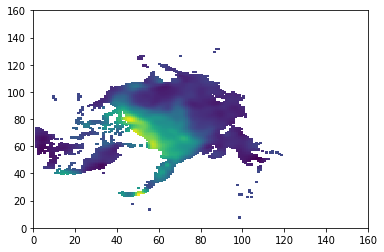

In [5]:
print(IS2_interp['20181201'].shape)
plt.pcolor(IS2_interp['20181201'])

In [6]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/Will_compare/freeboard_daily_interpolated/IS2/'
files = sorted(glob.glob(datapath+'FB_interp_'+season+'_50km_*.npy'))
fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[4][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

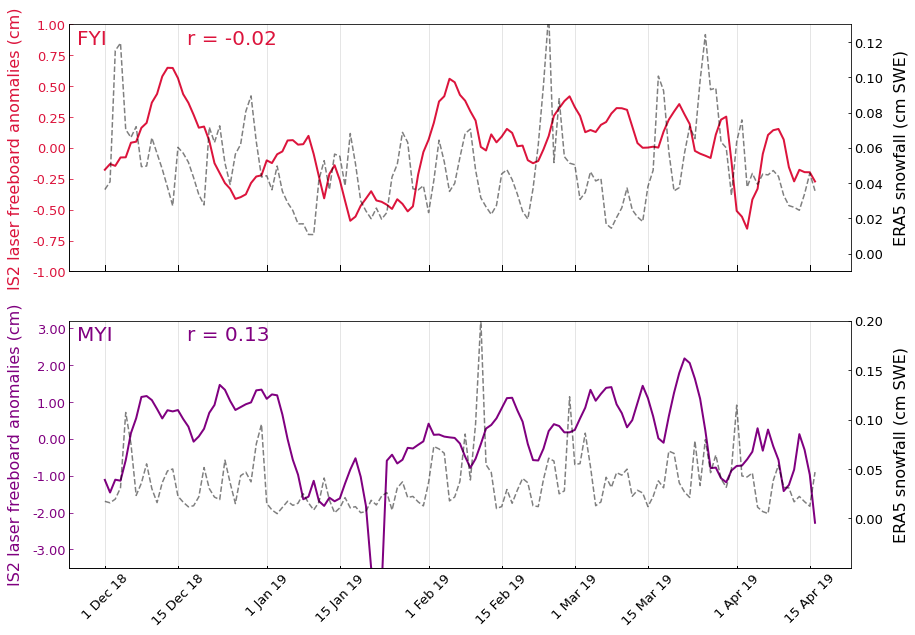

In [7]:
datapath='/Users/carmennab/PhD/OI_PolarSnow/'

#get grid cells which have been either FYI or MYI for the whole season
FYI_row = [] ; MYI_row = []
FYI_col = [] ; MYI_col = []
for i in range(dX):
    for j in range(dY):
        if (icetype_grid[i,j,:] == 2).all():
            FYI_row.append(i) ; FYI_col.append(j)
        elif (icetype_grid[i,j,:] == 3).all():
            MYI_row.append(i) ; MYI_col.append(j)
FYI = (FYI_row,FYI_col)
MYI = (MYI_row,MYI_col)
 
datelist=[]

for i, yearmonth in enumerate((201812, 201901, 201902, 201903, 201904)):
    year=int(str(yearmonth)[0:4])
    month=int(str(yearmonth)[4:6])
    days_in_month=(31,31,28,31,30)

    for Day in range(1,days_in_month[i]+1):

        day = "%02d" % Day
        date=str(yearmonth)+day

        date = datetime.datetime(year, month, Day)
        if day == '01':
            datelist.append(date.strftime("%-d %b %y"))
        elif day == '15':
            datelist.append(date.strftime("%-d %b %y"))
        elif ((yearmonth==201804) & (day == '30')):
            datelist.append(date.strftime("%-d %b %y"))
        else:
            datelist.append('')     

            
interp_mean = np.zeros((2,len(files)))
era5_mean = np.zeros((2,len(files)))
zones = [FYI,MYI]
for day in range(len(files)):
    stamp = files[day].split('/')[-1].split('_')[4][0:8]
    try:
        ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
    except:
        ERA5 = Dataset(datapath+'ERA5/daily-sf_'+str(int(stamp)-1)+'.nc')
    snow = np.array(ERA5['sf'])[0,:161,:] #i think 161 was the index which marked 60 degree latitude boundary
    era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
    era5_x,era5_y = m(era5_lon,era5_lat)
    snow = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
    for k in range(2):
        a = fb[:,:,day][zones[k]] ; b = snow[zones[k]]
        ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
        interp_mean[k,day] = np.nanmean(a[ID])
        #print(interp_mean[k,day])
        # I manually removed the interpolated files with only NaN values (most of april) bc couldn't figure out how to code it here, but they're still on the server if we need them
        era5_mean[k,day] = np.nanmean(b[ID])
        
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
colors = ['crimson','purple']
ylims = [[-1.0,1.0],[-3.5,3.2]]
ylims2 = [[-0.01,0.13],[-0.05,0.2]]
labels = ['FYI','MYI']
end = [1,2]
for k in range(2):
    ax[k].spines['top'].set_color('none')
    ax[k].spines['right'].set_color('none')
    p = np.polyfit(np.arange(137),interp_mean[k,:],2)
    anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
    snow = era5_mean[k,:]*100
    #anomalies = interp_mean[k,:]*5
    r = (stats.pearsonr(anomalies,snow)[0]).round(2)
    ylim = ylims[k]
    ax[k].plot(anomalies,colors[k],lw=2)
    ax[k].set_xticks(np.arange(len(datelist)))
    ax[k].set_xticklabels(datelist)
    ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
    ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax[k].set_ylabel('IS2 laser freeboard anomalies (cm)',labelpad=10,fontsize=16)
    ax[k].set_ylim(ylim)
    ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].yaxis.label.set_color(colors[k])
    ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax[k].tick_params(axis='y', colors=colors[k])
    ax2 = ax[k].twinx()
    ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax2.set_ylabel('ERA5 snowfall (cm SWE)',labelpad=10,fontsize=16)
    ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax2.set_ylim(ylims2[k])
    if k == 1:
        ax2.set_yticks([0.00,0.05,0.10,0.15,0.20])

    for i in range(len(datelist)):
    # If there is a label, plot a tick:
        if len(datelist[i]) > 0:
            # Plot grey grid line
            ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
            # Plot black tick
            ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

plt.subplots_adjust(hspace=0.2)
plt.show()

In [8]:
FYI_row = [] ; MYI_row = []
FYI_col = [] ; MYI_col = []
for i in range(dX):
    for j in range(dY):
        if (icetype_grid[i,j,:] == 2).all():
            FYI_row.append(i) ; FYI_col.append(j)
        elif (icetype_grid[i,j,:] == 3).all():
            MYI_row.append(i) ; MYI_col.append(j)
FYI = (FYI_row,FYI_col)
MYI = (MYI_row,MYI_col)

itype_mask = np.zeros((160,160))*np.nan
itype_mask[FYI] = 1
itype_mask[MYI] = 0

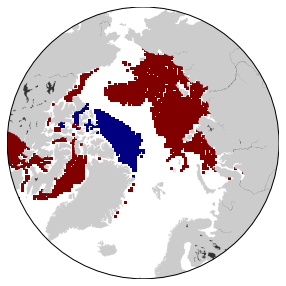

In [9]:
fig,ax = plt.subplots(1,figsize=(5,5))
m = Basemap(projection='npstere',boundinglat=60,lon_0=0, resolution='l',ax=ax,round=True)
m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
#m.drawlsmask(land_color=(0.5, 0.5, 0.5),ocean_color=(0.2, 0.2, 0.2))
m.pcolormesh(x,y,itype_mask,cmap='jet',vmin=0,vmax=.4,rasterized=True)
plt.show()

### 9 day running mean

In [10]:
datapath='/Users/carmennab/PhD/OI_PolarSnow/'
snows = np.zeros((160,160,len(files)))
for day in range(len(files)):
    stamp = files[day].split('/')[-1].split('_')[4][0:8]
    ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
    snow = np.array(ERA5['sf'])[0,:161,:]
    era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
    era5_x,era5_y = m(era5_lon,era5_lat)
    snows[:,:,day] = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')

zones = [FYI,MYI]
for day in range(len(files)):
    if (day >= 4) & (day <= 140):
        freeboard = np.nanmean(fb[:,:,day-4:day+5],2)
        snow_total = np.nansum(snows[:,:,day-4:day+5],2)
        for k in range(2):
            a = freeboard[zones[k]] ; b = snow_total[zones[k]]
            ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
            interp_mean[k,day] = np.nanmean(a[ID])
            era5_mean[k,day] = np.nanmean(b[ID])

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_5277/705593384.py:14: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


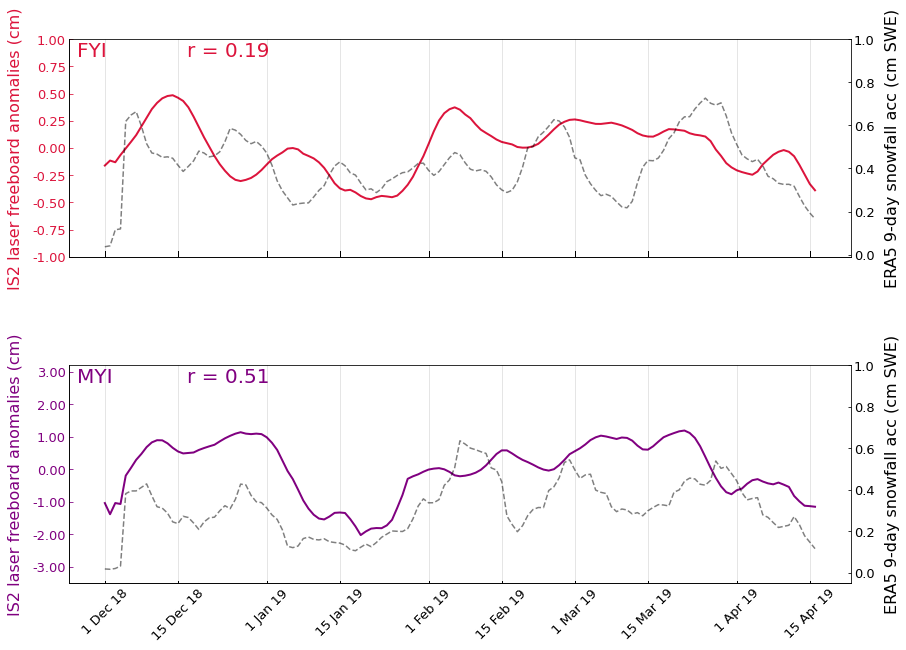

In [11]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
colors = ['crimson','purple']
ylims = [[-1.0,1.0],[-3.5,3.2]]
ylims2 = [[-0.01,1.0],[-0.05,1.0]]
labels = ['FYI','MYI']
end = [1,2]
for k in range(2):
    ax[k].spines['top'].set_color('none')
    ax[k].spines['right'].set_color('none')
    p = np.polyfit(np.arange(137),interp_mean[k,:],2)
    anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
    snow = era5_mean[k,:]*100
    #anomalies = interp_mean[k,:]*5
    r = (stats.pearsonr(anomalies,snow)[0]).round(2)
    ylim = ylims[k]
    ax[k].plot(anomalies,colors[k],lw=2)
    ax[k].set_xticks(np.arange(len(datelist)))
    ax[k].set_xticklabels(datelist)
    ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
    ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax[k].set_ylabel('IS2 laser freeboard anomalies (cm)',labelpad=10,fontsize=16)
    ax[k].set_ylim(ylim)
    ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].yaxis.label.set_color(colors[k])
    ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax[k].tick_params(axis='y', colors=colors[k])
    ax2 = ax[k].twinx()
    ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax2.set_ylabel('ERA5 9-day snowfall acc (cm SWE)',labelpad=10,fontsize=16)
    ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax2.set_ylim(ylims2[k])
#    if k == 1:
#        ax2.set_yticks([0.00,0.05,0.10,0.15,0.20])

    for i in range(len(datelist)):
    # If there is a label, plot a tick:
        if len(datelist[i]) > 0:
            # Plot grey grid line
            ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
            # Plot black tick
            ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

plt.subplots_adjust(hspace=0.5)
plt.show()

# AK Oct 2018 - April 2019

In [12]:
def readFB(grid_res,season):
    f = open(datapath+'/AK/dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    AK = pickle.load(f)
    f = open(datapath+'/SIE_masking_'+str(grid_res)+'km_'+season+'_season.pkl','rb')
    SIE = pickle.load(f)
    f.close()
    obs = []
    zb = []
    dates = []
    for key in AK:
        obs.append([AK[key]])
        zb.append(SIE[key])
        dates.append(key)
    obs = np.array(obs).transpose(2,3,1,0)
    zb = np.array(zb).transpose(1,2,0)
    zb[zb<0.15] = np.nan
    return obs,zb,dates

def orthoreg(x, y):
    from scipy.stats import linregress
    from scipy.odr import Model, Data, ODR
    """Perform an Orthogonal Distance Regression on the given data,
    using the same interface as the standard scipy.stats.linregress function.

    Arguments:
    x: x data
    y: y data

    Returns:
    [m, c, nan, nan, nan]

    Uses standard ordinary least squares to estimate the starting parameters
    then uses the scipy.odr interface to the ODRPACK Fortran code to do the
    orthogonal distance calculations.
    """
    def f(p, x):
        """Basic linear regression 'model' for use with ODR"""
        return (p[0] * x) + p[1]

    linreg = linregress(x, y)
    mod = Model(f)
    dat = Data(x, y)
    od = ODR(dat, mod, beta0=linreg[0:2])
    out = od.run()

    return list(out.beta)
    
grid_res = 50
season = '2018-2019'
m = Basemap(projection='npstere',boundinglat=60,lon_0=0,resolution='l',round=True)
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
x = np.load(datapath+'/x_'+str(grid_res)+'km.npy')
y = np.load(datapath+'/y_'+str(grid_res)+'km.npy')
lon,lat = m(x,y,inverse=True)

T=9
T_mid=T//2
obs,zb,dates = readFB(grid_res,season)
dX,dY = obs.shape[0],obs.shape[1]

In [13]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_processed'
def download(date):
    date_split = list(date)
    year = date_split[0]+date_split[1]+date_split[2]+date_split[3]
    month = date_split[4]+date_split[5]
    import shutil
    import urllib.request as request
    from contextlib import closing
    with closing(request.urlopen('ftp://osisaf.met.no//archive/ice/type/'+year+'/'+month+'//ice_type_nh_polstere-100_multi_'+date+'1200.nc')) as r:
        with open(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+date+'1200.nc', 'wb') as f:
            shutil.copyfileobj(r, f)

if os.path.exists(datapath+'/icetype_'+str(grid_res)+'km_'+season+'.npy')==False:
    if os.path.exists(datapath+'/icetype')==False:
        os.mkdir(datapath+'/icetype')
    f = open(datapath+'/AK/dailyFB_'+str(grid_res)+'km_'+season+'_season.pkl','rb')

    AK_all = pickle.load(f)
    AK_FYI = np.zeros((dX,dY,len(AK_all)))*np.nan
    AK_MYI = np.zeros((dX,dY,len(AK_all)))*np.nan
    icetype_grid = np.zeros((dX,dY,len(AK_all)))*np.nan
    AK_dates = []
    k = 0
    for key in AK_all: #key is a date, so looping through each day for which we have gridded CS2 obs in this season
        print('Downloading OSI-SAF icetype: ',key)
        download(key)
        AK_dates.append(key)
        try:
            AK = AK_all[key]
        except:
            print('KeyError')
        fbFYI = np.zeros((dX,dY))*np.nan
        fbMYI = np.zeros((dX,dY))*np.nan
        icetype = Dataset(datapath+'/icetype/ice_type_nh_polstere-100_multi_'+str(key)+'1200.nc')
        icetype_lon = np.array(icetype['lon'])
        icetype_lat = np.array(icetype['lat'])
        icetype_x,icetype_y = m(icetype_lon,icetype_lat)
        itype = np.array(icetype['ice_type']).astype('float32')[0,:,:]
        itype[itype>3] = np.nan
        itype[itype<2] = np.nan
        icetype_grid[:,:,k] = griddata((icetype_x.ravel(),icetype_y.ravel()),itype.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
        FYI = np.where(icetype_grid[:,:,k]==2)
        MYI = np.where(icetype_grid[:,:,k]==3)
        fbFYI[FYI] = AK[FYI]
        fbMYI[MYI] = AK[MYI]
        AK_FYI[:,:,k] = fbFYI
        AK_MYI[:,:,k] = fbMYI
        k += 1
    np.save(datapath+'/AK_'+str(grid_res)+'km_FYI_'+season+'.npy',AK_FYI)
    np.save(datapath+'/AK_'+str(grid_res)+'km_MYI_'+season+'.npy',AK_MYI)
    np.save(datapath+'/AK_'+str(grid_res)+'km_'+season+'.npy',icetype_grid)
else:
    AK_FYI = np.load(datapath+'/AK_'+str(grid_res)+'km_FYI_'+season+'.npy')
    AK_MYI = np.load(datapath+'/AK_'+str(grid_res)+'km_MYI_'+season+'.npy')
    icetype_grid = np.load(datapath+'/icetype_'+str(grid_res)+'km_'+season+'.npy')

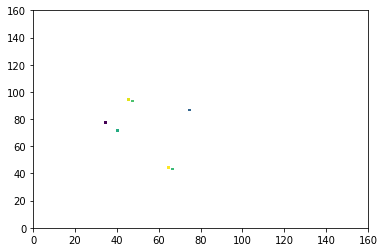

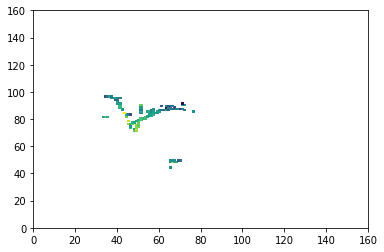

In [14]:
plt.pcolor(AK_FYI[:,:,0])
plt.show()
plt.pcolor(AK_MYI[:,:,0])

In [15]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/AK/'
files = sorted(glob.glob(datapath+'FB_interp_2018-2019_50km_*.npy'))

AK_interp = {}
for day in range(len(files)):
    file = files[day-1]
    datez = file.split('_')
    date1 = datez[7]
    date2 = date1.split('.')
    date=date2[0]
    AK_interp[date]= np.load(datapath+'FB_interp_2018-2019_50km_'+str(date)+'.npy')

(160, 160)


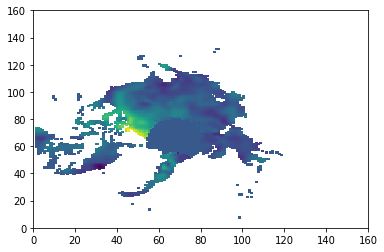

In [16]:
print(AK_interp['20181201'].shape)
plt.pcolor(AK_interp['20181201'])

In [17]:
datapath = '/Users/carmennab/PhD/OI_PolarSnow/freeboard_daily_interpolated/AK/'
files = sorted(glob.glob(datapath+'FB_interp_'+season+'_50km_*.npy'))
fb = np.zeros((dX,dY,len(files)))
k = 0
for file in files:
    date = file.split('/')[-1].split('_')[4][0:8]
    fb[:,:,k] = np.load(file)
    k += 1

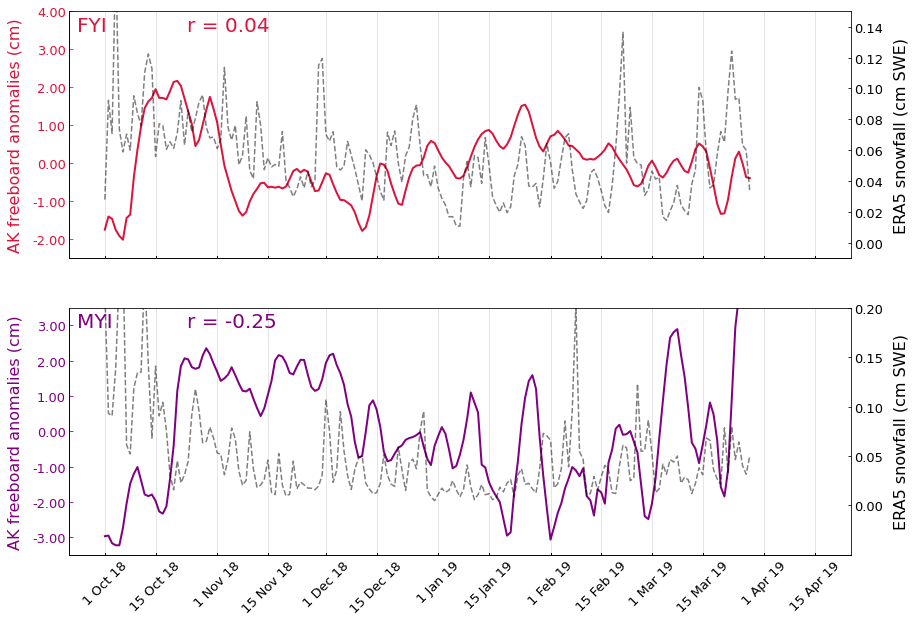

In [18]:
datapath='/Users/carmennab/PhD/OI_PolarSnow/'

#get grid cells which have been either FYI or MYI for the whole season
FYI_row = [] ; MYI_row = []
FYI_col = [] ; MYI_col = []
for i in range(dX):
    for j in range(dY):
        if (icetype_grid[i,j,:] == 2).all():
            FYI_row.append(i) ; FYI_col.append(j)
        elif (icetype_grid[i,j,:] == 3).all():
            MYI_row.append(i) ; MYI_col.append(j)
FYI = (FYI_row,FYI_col)
MYI = (MYI_row,MYI_col)
 
datelist=[]

for i, yearmonth in enumerate((201810,201811,201812, 201901, 201902, 201903, 201904)):
    year=int(str(yearmonth)[0:4])
    month=int(str(yearmonth)[4:6])
    days_in_month=(31,30,31,31,28,31,30)

    for Day in range(1,days_in_month[i]+1):

        day = "%02d" % Day
        date=str(yearmonth)+day

        date = datetime.datetime(year, month, Day)
        if day == '01':
            datelist.append(date.strftime("%-d %b %y"))
        elif day == '15':
            datelist.append(date.strftime("%-d %b %y"))
        elif ((yearmonth==201804) & (day == '30')):
            datelist.append(date.strftime("%-d %b %y"))
        else:
            datelist.append('')     

            
interp_mean = np.zeros((2,len(files)))
era5_mean = np.zeros((2,len(files)))
zones = [FYI,MYI]
for day in range(len(files)):
    stamp = files[day].split('/')[-1].split('_')[4][0:8]
    try:
        ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
    except:
        ERA5 = Dataset(datapath+'ERA5/daily-sf_'+str(int(stamp)-1)+'.nc')
    snow = np.array(ERA5['sf'])[0,:161,:] #i think 161 was the index which marked 60 degree latitude boundary
    era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
    era5_x,era5_y = m(era5_lon,era5_lat)
    snow = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
    for k in range(2):
        a = fb[:,:,day][zones[k]] ; b = snow[zones[k]]
        ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
        interp_mean[k,day] = np.nanmean(a[ID])
        #print(interp_mean[k,day])
        # I manually removed the interpolated files with only NaN values (most of april) bc couldn't figure out how to code it here, but they're still on the server if we need them
        era5_mean[k,day] = np.nanmean(b[ID])
        
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
colors = ['crimson','purple']
ylims = [[-2.5,4.0],[-3.5,3.5]]
ylims2 = [[-0.01,0.15],[-0.05,0.2]]
labels = ['FYI','MYI']
end = [1,2]
for k in range(2):
    ax[k].spines['top'].set_color('none')
    ax[k].spines['right'].set_color('none')
    p = np.polyfit(np.arange(len(files)),interp_mean[k,:],2)
    anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
    snow = era5_mean[k,:]*100
    #anomalies = interp_mean[k,:]*5
    r = (stats.pearsonr(anomalies,snow)[0]).round(2)
    ylim = ylims[k]
    ax[k].plot(anomalies,colors[k],lw=2)
    ax[k].set_xticks(np.arange(len(datelist)))
    ax[k].set_xticklabels(datelist)
    ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
    ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax[k].set_ylabel('AK freeboard anomalies (cm)',labelpad=10,fontsize=16)
    ax[k].set_ylim(ylim)
    ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].yaxis.label.set_color(colors[k])
    ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax[k].tick_params(axis='y', colors=colors[k])
    ax2 = ax[k].twinx()
    ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax2.set_ylabel('ERA5 snowfall (cm SWE)',labelpad=10,fontsize=16)
    ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax2.set_ylim(ylims2[k])
    if k == 1:
        ax2.set_yticks([0.00,0.05,0.10,0.15,0.20])

    for i in range(len(datelist)):
    # If there is a label, plot a tick:
        if len(datelist[i]) > 0:
            # Plot grey grid line
            ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
            # Plot black tick
            ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

plt.subplots_adjust(hspace=0.2)
plt.show()

In [19]:
FYI_row = [] ; MYI_row = []
FYI_col = [] ; MYI_col = []
for i in range(dX):
    for j in range(dY):
        if (icetype_grid[i,j,:] == 2).all():
            FYI_row.append(i) ; FYI_col.append(j)
        elif (icetype_grid[i,j,:] == 3).all():
            MYI_row.append(i) ; MYI_col.append(j)
FYI = (FYI_row,FYI_col)
MYI = (MYI_row,MYI_col)

itype_mask = np.zeros((160,160))*np.nan
itype_mask[FYI] = 1
itype_mask[MYI] = 0

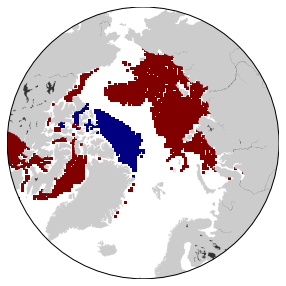

In [20]:
fig,ax = plt.subplots(1,figsize=(5,5))
m = Basemap(projection='npstere',boundinglat=60,lon_0=0, resolution='l',ax=ax,round=True)
m.fillcontinents(color=(0.8, 0.8, 0.8),lake_color=(0.2, 0.2, 0.2))
#m.drawlsmask(land_color=(0.5, 0.5, 0.5),ocean_color=(0.2, 0.2, 0.2))
m.pcolormesh(x,y,itype_mask,cmap='jet',vmin=0,vmax=.4,rasterized=True)
plt.show()

## 9 day running mean

In [21]:
datapath='/Users/carmennab/PhD/OI_PolarSnow/'
snows = np.zeros((160,160,len(files)))
for day in range(len(files)):
    stamp = files[day].split('/')[-1].split('_')[4][0:8]
    ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
    snow = np.array(ERA5['sf'])[0,:161,:]
    era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
    era5_x,era5_y = m(era5_lon,era5_lat)
    snows[:,:,day] = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')

zones = [FYI,MYI]
for day in range(len(files)):
    if (day >= 4) & (day <= 140):
        freeboard = np.nanmean(fb[:,:,day-4:day+5],2)
        snow_total = np.nansum(snows[:,:,day-4:day+5],2)
        for k in range(2):
            a = freeboard[zones[k]] ; b = snow_total[zones[k]]
            ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
            interp_mean[k,day] = np.nanmean(a[ID])
            era5_mean[k,day] = np.nanmean(b[ID])

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_5277/705593384.py:14: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


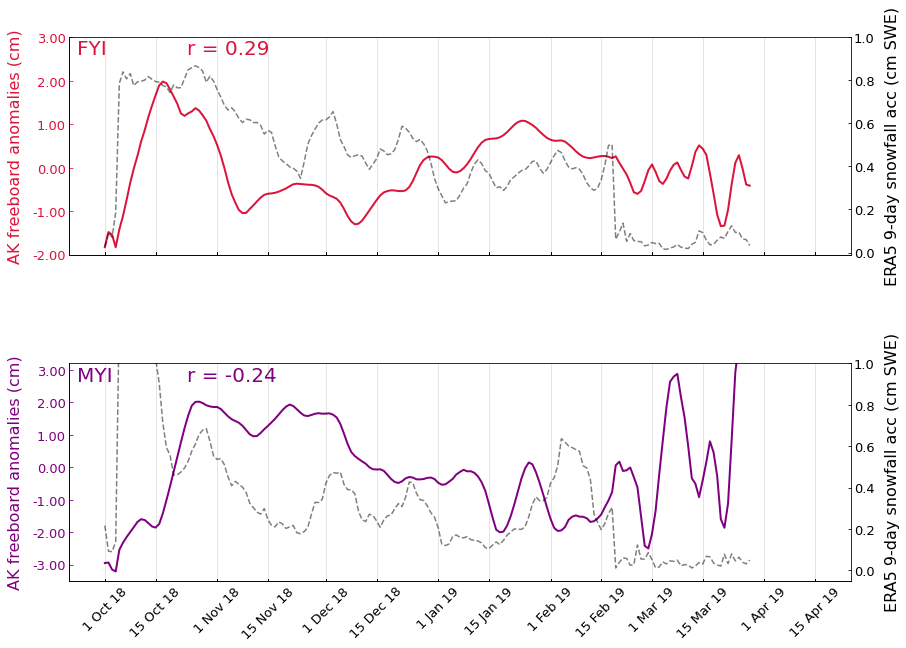

In [22]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
colors = ['crimson','purple']
ylims = [[-2.0,3.0],[-3.5,3.2]]
ylims2 = [[-0.01,1.0],[-0.05,1.0]]
labels = ['FYI','MYI']
end = [1,2]
for k in range(2):
    ax[k].spines['top'].set_color('none')
    ax[k].spines['right'].set_color('none')
    p = np.polyfit(np.arange(len(files)),interp_mean[k,:],2)
    anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
    snow = era5_mean[k,:]*100
    #anomalies = interp_mean[k,:]*5
    r = (stats.pearsonr(anomalies,snow)[0]).round(2)
    ylim = ylims[k]
    ax[k].plot(anomalies,colors[k],lw=2)
    ax[k].set_xticks(np.arange(len(datelist)))
    ax[k].set_xticklabels(datelist)
    ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
    ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax[k].set_ylabel('AK freeboard anomalies (cm)',labelpad=10,fontsize=16)
    ax[k].set_ylim(ylim)
    ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].yaxis.label.set_color(colors[k])
    ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax[k].tick_params(axis='y', colors=colors[k])
    ax2 = ax[k].twinx()
    ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax2.set_ylabel('ERA5 9-day snowfall acc (cm SWE)',labelpad=10,fontsize=16)
    ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax2.set_ylim(ylims2[k])
#    if k == 1:
#        ax2.set_yticks([0.00,0.05,0.10,0.15,0.20])

    for i in range(len(datelist)):
    # If there is a label, plot a tick:
        if len(datelist[i]) > 0:
            # Plot grey grid line
            ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
            # Plot black tick
            ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

plt.subplots_adjust(hspace=0.5)
plt.show()

# AK Dec 2018 - April 2019

In [23]:
files = files[57:]
files
print(len(files))

122


20181201
20181202
20181203
20181204
20181205
20181206
20181207
20181208
20181209
20181210
20181211
20181212
20181213
20181214
20181215
20181216
20181217
20181218
20181219
20181220
20181221
20181222
20181223
20181224
20181225
20181226
20181227
20181228
20181229
20181230
20181231
20190101
20190102
20190103
20190104
20190105
20190106
20190107
20190108
20190109
20190110
20190111
20190112
20190113
20190114
20190115
20190116
20190117
20190118
20190119
20190120
20190121
20190122
20190123
20190124
20190125
20190126
20190127
20190128
20190129
20190130
20190131
20190201
20190202
20190203
20190204
20190205
20190206
20190207
20190208
20190209
20190210
20190211
20190212
20190213
20190214
20190215
20190216
20190217
20190218
20190219
20190220
20190221
20190222
20190223
20190224
20190225
20190226
20190227
20190228
20190301
20190302
20190303
20190304
20190305
20190306
20190307
20190308
20190309
20190310
20190311
20190312
20190313
20190314
20190315
20190316
20190317
20190318
20190319
20190320
20190321
2

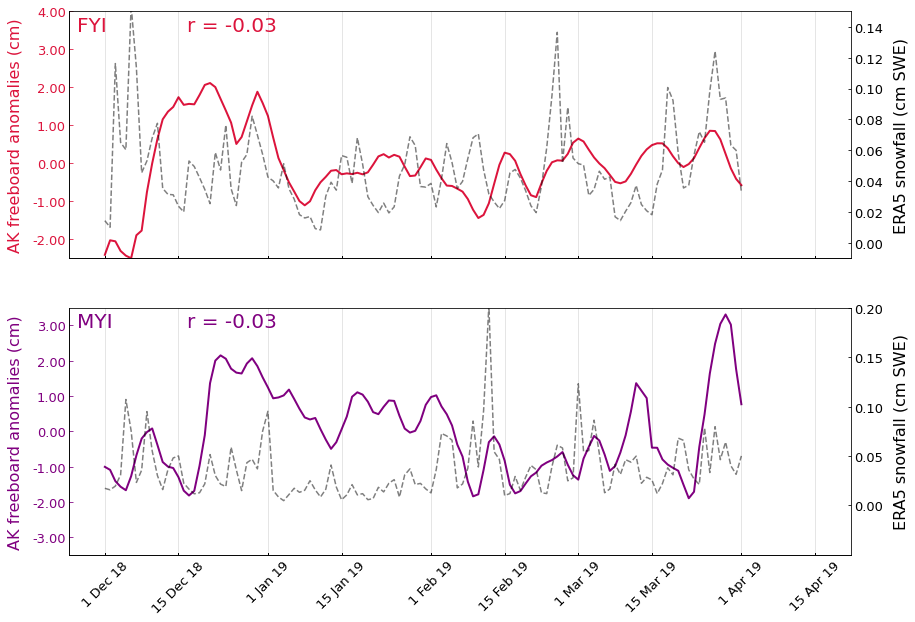

In [24]:
datapath='/Users/carmennab/PhD/OI_PolarSnow/'

#get grid cells which have been either FYI or MYI for the whole season
FYI_row = [] ; MYI_row = []
FYI_col = [] ; MYI_col = []
for i in range(dX):
    for j in range(dY):
        if (icetype_grid[i,j,:] == 2).all():
            FYI_row.append(i) ; FYI_col.append(j)
        elif (icetype_grid[i,j,:] == 3).all():
            MYI_row.append(i) ; MYI_col.append(j)
FYI = (FYI_row,FYI_col)
MYI = (MYI_row,MYI_col)
 
datelist=[]

for i, yearmonth in enumerate((201812, 201901, 201902, 201903, 201904)):
    year=int(str(yearmonth)[0:4])
    month=int(str(yearmonth)[4:6])
    days_in_month=(31,31,28,31,30)

    for Day in range(1,days_in_month[i]+1):

        day = "%02d" % Day
        date=str(yearmonth)+day

        date = datetime.datetime(year, month, Day)
        if day == '01':
            datelist.append(date.strftime("%-d %b %y"))
        elif day == '15':
            datelist.append(date.strftime("%-d %b %y"))
        elif ((yearmonth==201804) & (day == '30')):
            datelist.append(date.strftime("%-d %b %y"))
        else:
            datelist.append('')     

            
interp_mean = np.zeros((2,len(files)))
era5_mean = np.zeros((2,len(files)))
zones = [FYI,MYI]
for day in range(len(files)):
    stamp = files[day].split('/')[-1].split('_')[4][0:8]
    print(stamp)
    try:
        ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
    except:
        ERA5 = Dataset(datapath+'ERA5/daily-sf_'+str(int(stamp)-1)+'.nc')
    snow = np.array(ERA5['sf'])[0,:161,:] #i think 161 was the index which marked 60 degree latitude boundary
    era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
    era5_x,era5_y = m(era5_lon,era5_lat)
    snow = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')
    for k in range(2):
        a = fb[:,:,day][zones[k]] ; b = snow[zones[k]]
        ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
        interp_mean[k,day] = np.nanmean(a[ID])
        #print(interp_mean[k,day])
        # I manually removed the interpolated files with only NaN values (most of april) bc couldn't figure out how to code it here, but they're still on the server if we need them
        era5_mean[k,day] = np.nanmean(b[ID])
        
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
colors = ['crimson','purple']
ylims = [[-2.5,4.0],[-3.5,3.5]]
ylims2 = [[-0.01,0.15],[-0.05,0.2]]
labels = ['FYI','MYI']
end = [1,2]
for k in range(2):
    ax[k].spines['top'].set_color('none')
    ax[k].spines['right'].set_color('none')
    p = np.polyfit(np.arange(len(files)),interp_mean[k,:],2)
    anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
    snow = era5_mean[k,:]*100
    #anomalies = interp_mean[k,:]*5
    r = (stats.pearsonr(anomalies,snow)[0]).round(2)
    ylim = ylims[k]
    ax[k].plot(anomalies,colors[k],lw=2)
    ax[k].set_xticks(np.arange(len(datelist)))
    ax[k].set_xticklabels(datelist)
    ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
    ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax[k].set_ylabel('AK freeboard anomalies (cm)',labelpad=10,fontsize=16)
    ax[k].set_ylim(ylim)
    ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].yaxis.label.set_color(colors[k])
    ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax[k].tick_params(axis='y', colors=colors[k])
    ax2 = ax[k].twinx()
    ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax2.set_ylabel('ERA5 snowfall (cm SWE)',labelpad=10,fontsize=16)
    ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax2.set_ylim(ylims2[k])
    if k == 1:
        ax2.set_yticks([0.00,0.05,0.10,0.15,0.20])

    for i in range(len(datelist)):
    # If there is a label, plot a tick:
        if len(datelist[i]) > 0:
            # Plot grey grid line
            ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
            # Plot black tick
            ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

plt.subplots_adjust(hspace=0.2)
plt.show()

## 9 day running mean

In [26]:
datapath='/Users/carmennab/PhD/OI_PolarSnow/'
snows = np.zeros((160,160,len(files)))
for day in range(len(files)):
    stamp = files[day].split('/')[-1].split('_')[4][0:8]
    ERA5 = Dataset(datapath+'ERA5/daily-sf_'+stamp+'.nc')
    snow = np.array(ERA5['sf'])[0,:161,:]
    era5_lon,era5_lat = np.meshgrid(np.array(ERA5['longitude']),np.array(ERA5['latitude'][:161]))
    era5_x,era5_y = m(era5_lon,era5_lat)
    snows[:,:,day] = griddata((era5_x.ravel(),era5_y.ravel()),snow.ravel(),(x[:-1,:-1],y[:-1,:-1]),'nearest')

zones = [FYI,MYI]
for day in range(len(files)):
    if (day >= 4) & (day <= 140):
        freeboard = np.nanmean(fb[:,:,day-4:day+5],2)
        snow_total = np.nansum(snows[:,:,day-4:day+5],2)
        for k in range(2):
            a = freeboard[zones[k]] ; b = snow_total[zones[k]]
            ID = np.where((~np.isnan(a)) & (~np.isnan(b)))
            interp_mean[k,day] = np.nanmean(a[ID])
            era5_mean[k,day] = np.nanmean(b[ID])

/var/folders/_1/fh2vf5m57871c546k_sf7xr80000gn/T/ipykernel_5277/705593384.py:14: RuntimeWarning: Mean of empty slice
  freeboard = np.nanmean(fb[:,:,day-4:day+5],2)


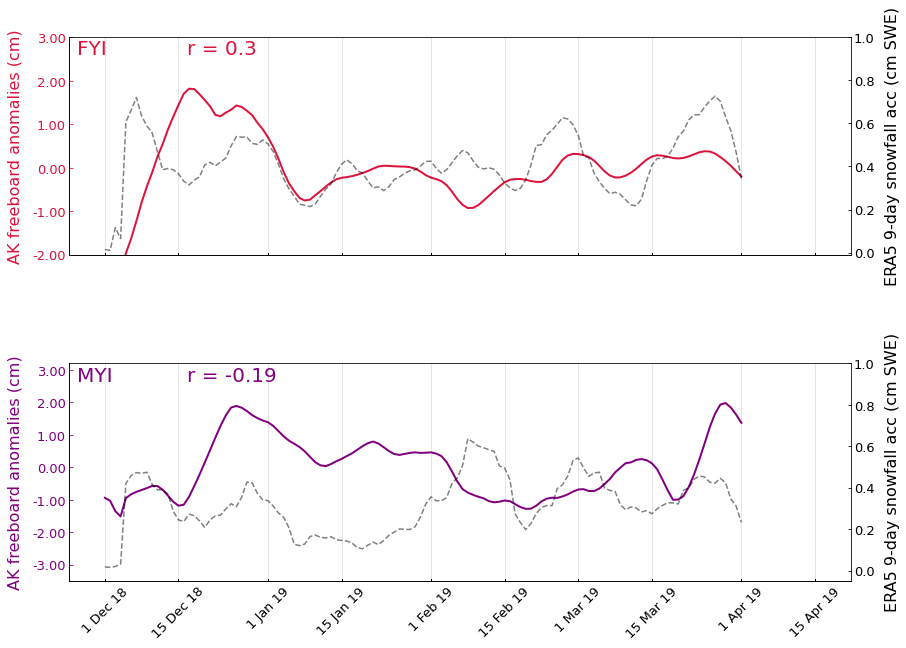

In [27]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(14,10))
colors = ['crimson','purple']
ylims = [[-2.0,3.0],[-3.5,3.2]]
ylims2 = [[-0.01,1.0],[-0.05,1.0]]
labels = ['FYI','MYI']
end = [1,2]
for k in range(2):
    ax[k].spines['top'].set_color('none')
    ax[k].spines['right'].set_color('none')
    p = np.polyfit(np.arange(len(files)),interp_mean[k,:],2)
    anomalies = 100*(interp_mean[k,:]-np.polyval(p,np.arange(len(files))))
    snow = era5_mean[k,:]*100
    #anomalies = interp_mean[k,:]*5
    r = (stats.pearsonr(anomalies,snow)[0]).round(2)
    ylim = ylims[k]
    ax[k].plot(anomalies,colors[k],lw=2)
    ax[k].set_xticks(np.arange(len(datelist)))
    ax[k].set_xticklabels(datelist)
    ax[k].tick_params(axis="x",which='both',direction='in',length=0,labelsize=13,rotation=45)
    ax[k].tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax[k].set_ylabel('AK freeboard anomalies (cm)',labelpad=10,fontsize=16)
    ax[k].set_ylim(ylim)
    ax[k].text(0.01,0.92,labels[k],color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].text(0.15,0.92,'r = '+str(r),color=colors[k],transform=ax[k].transAxes,fontsize=20)
    ax[k].yaxis.label.set_color(colors[k])
    ax[k].yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%.2f'))
    ax[k].tick_params(axis='y', colors=colors[k])
    ax2 = ax[k].twinx()
    ax2.plot(snow,'k',linestyle='--',linewidth=1.5,alpha=0.5)
    ax2.set_ylabel('ERA5 9-day snowfall acc (cm SWE)',labelpad=10,fontsize=16)
    ax2.tick_params(axis="y",which='both',direction='in',labelsize=13)
    ax2.set_ylim(ylims2[k])
#    if k == 1:
#        ax2.set_yticks([0.00,0.05,0.10,0.15,0.20])

    for i in range(len(datelist)):
    # If there is a label, plot a tick:
        if len(datelist[i]) > 0:
            # Plot grey grid line
            ax[k].plot((i,i),(ylim[0],ylim[1]),color='black',alpha=0.1,lw=1)
            # Plot black tick
            ax[k].plot((i,i),(ylim[0],ylim[0]+0.05),color='black',lw=1)

plt.subplots_adjust(hspace=0.5)
plt.show()